## Imports

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.model import RnnDlModel, LinearRegressionBaselineModel, DummyModel
from bitcoin_deep_learning.trainer import train, read_result
from bitcoin_deep_learning.cross_val import get_cross_XY
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
import joblib
%load_ext autoreload
%autoreload 2

## Getting data

In [23]:
train_df = ApiCall().read_local(data='train')#.drop(columns = '[%]_Bitcoin_growth_rate_on_Horizon=7')

In [24]:
X_train_list, Y_train_list, X_test_list,Y_test_list = get_cross_XY()

In [25]:
np.array(X_train_list).shape

(32, 263, 90, 32)

In [26]:
train_df.head(3)

date  [AVG]_[NH]_mean_hash_rate  [+]_[NH]_Days_Till_Halving  \
0  2018-02-01               2.054109e+19                         830   
1  2018-02-02               2.170824e+19                         829   
2  2018-02-03               2.073919e+19                         828   

   [//]_[AV]_Stock-to-Flow_Ratio  [+]_[NH]_Circulating_Supply  \
0                    5642.903220                   16839700.0   
1                    5641.695528                   16841800.0   
2                    5641.015128                   16843775.0   

   [+]_[NH]_Issuance  [+]_[NH]_Number_of_Active_Addresses  \
0             2000.0                               842398   
1             2100.0                               854253   
2             1975.0                               714655   

   [+]_[NH]_Mean_Block_Interval  [+]_[NH]_Number_of_Transactions  \
0                           377                           257504   
1                           385                           235750   
2                           384                           194733   

   [+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance  ...  \
0                                           27026398     ...   
1                                           26955617     ...   
2                                           26886977     ...   

   [//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio  fear_greed_value  \
0                                         0.003691                30   
1                                         0.002557                15   
2                                         0.001970                40   

   [+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1  \
0                                            4226306      
1                                            4198274      
2                                            4173275      

   [+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1  \
0                                            1722331   
1                                            1704275   
2                                            1692828   

   [+]_[NH]_Number_of_Addresses_with_Balance_1 - 10  \
0                                            544769   
1                                            543489   
2                                            542447   

   [+]_[NH]_Number_of_Addresses_with_Balance_10 - 100  \
0                                             132314    
1                                             132213    
2                                             132021    

   [+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k  \
0                                              15779    
1                                              15815    
2                                              15812    

   [+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k  [+]_[T]_Bitcoin_Price  \
0                                               1529             9014.026207   
1                                               1521             8799.121911   
2                                               1523             9208.459919   

   [%]_Bitcoin_growth_rate_on_Horizon=7  
0                             -0.235616  
1                             -0.260491  
2                             -0.230759  

[3 rows x 33 columns]

## Data viz exploration

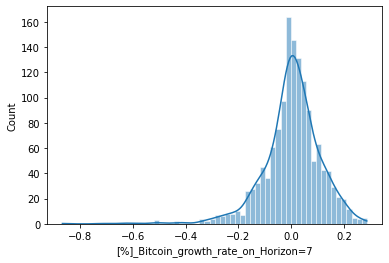

In [27]:
sns.histplot(train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'], kde=True, edgecolor='w');

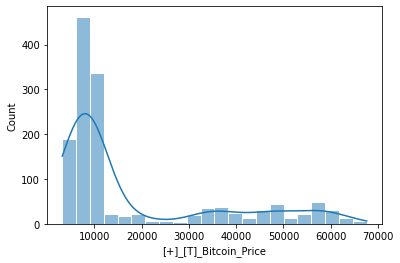

In [28]:
sns.histplot(train_df['[+]_[T]_Bitcoin_Price'], kde=True, edgecolor='w');

## Ploting models

### Plotting prediction per folds

In [83]:
def plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, model):
    fig, axs = plt.subplots(nrows = len(X_train_list), ncols = 2, figsize = (17,150))
    for k in range(len(X_train_list)):
        X_train, y_train, X_test, y_test = X_train_list[k], Y_train_list[k], X_test_list[k], Y_test_list[k]
        #intuition too much regularization on the lasso
        model.set_model()
        #model.fit(model.preproc(X_test, X_train)[1], y_train)
        y_pred = model.run(X_test, X_train, y_train)
        axs[k, 0].plot(y_test, label = 'test')
        axs[k, 0].plot(y_pred, color = 'r', label = 'pred')
        axs[k, 0].set_title('Fitting of y_test, y_pred')
        axs[k, 0].legend()
        axs[k, 1].plot(y_train, label = 'train', color = 'g')
        axs[k, 1].set_title('Evolution of the y_train')
        axs[k, 1].legend();

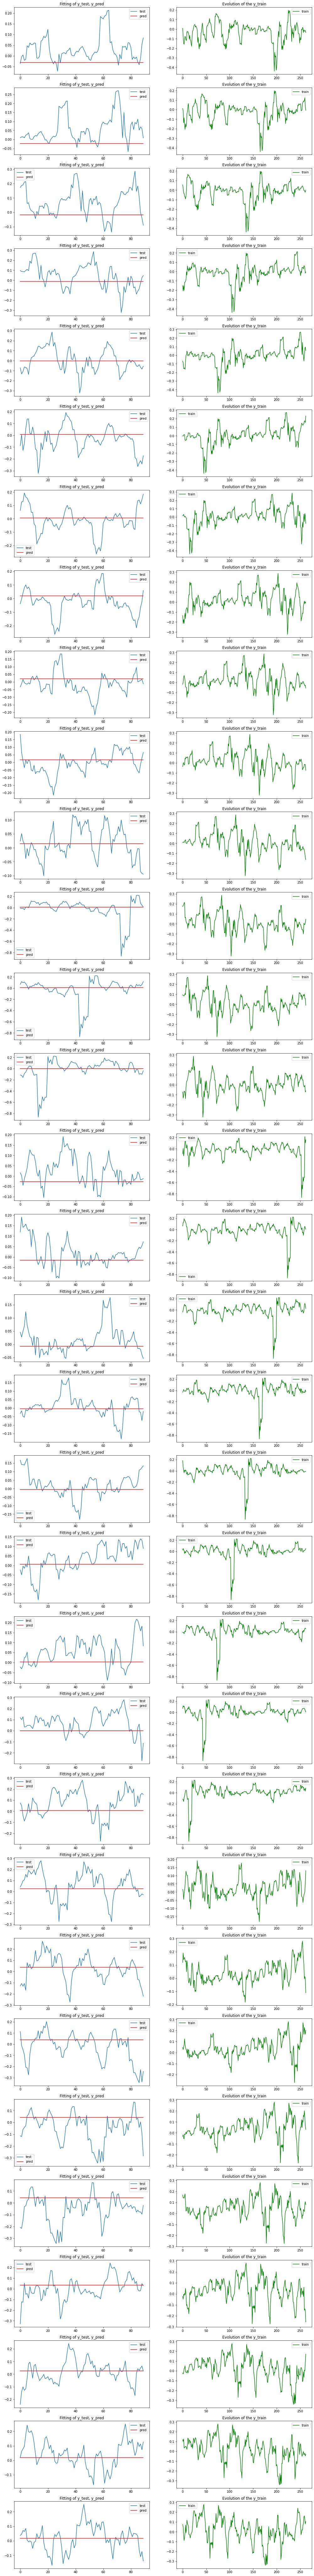

In [84]:
alpha = 15
l1 = 0.003
plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, LinearRegressionBaselineModel(alpha = alpha , l1_ratio = l1))

In [31]:
#ypred j+7 - ypred j+1 / ypred j+7
#ypred_diff.apply(lambda x: x*())

## Analysing Coefs

### Elastic Net training

In [62]:
model_regression = LinearRegressionBaselineModel(alpha = 15 , l1_ratio = 0.0001)
train(model_regression, train_df)
model_regression.model.coef_

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 36.00it/s]

Training done


array([-2.54152918e-04,  3.58268202e-04, -6.01667754e-04, -3.83037574e-04,
       -0.00000000e+00, -1.25682337e-04, -0.00000000e+00,  0.00000000e+00,
       -7.07606495e-04,  5.43265112e-04,  5.11587427e-04, -4.25108418e-04,
       -8.20516787e-05, -5.59423833e-04,  3.93966703e-04, -1.21793288e-04,
        0.00000000e+00, -0.00000000e+00, -7.69767707e-04, -0.00000000e+00,
       -9.71035352e-05, -2.70870581e-04, -0.00000000e+00,  1.76969734e-04,
       -6.24785677e-04, -6.92935286e-04,  0.00000000e+00,  6.66923740e-04,
       -4.02985371e-04,  1.82662879e-04, -6.91898433e-04, -0.00000000e+00])

In [64]:
train_df_matrix = train_df.copy().drop(columns = 'date')
len(train_df_matrix.columns)

32

In [65]:
coeff_matrix = pd.DataFrame(zip(train_df_matrix.columns,model_regression.model.coef_))
coeff_matrix = coeff_matrix.rename(columns={0: "features", 1: "coeff"})
coeff_matrix_absolute = coeff_matrix.copy()
coeff_matrix_absolute['coeff abs'] = coeff_matrix['coeff'].apply(abs)
coeff_matrix_absolute = coeff_matrix_absolute.drop(columns = 'coeff')
coeff_matrix_absolute.sort_values(by = 'coeff abs', ascending = False).reset_index(drop = True)

features  coeff abs
0                            [$]_[BSB]_Realized_Price   0.000770
1   [+]_[NH]_Number_of_Addresses_with_a_Non-Zero_B...   0.000708
2   [+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1   0.000693
3                               [+]_[T]_Bitcoin_Price   0.000692
4   [+]_[NH]_Number_of_Addresses_with_Balance_10 -...   0.000667
5   [+]_[NH]_Number_of_Addresses_with_Balance_0.01...   0.000625
6                       [//]_[AV]_Stock-to-Flow_Ratio   0.000602
7                               [//]_[BSB]_Liveliness   0.000559
8     [+]_[NH]_Number_of_Addresses_with_Balance_≥_10k   0.000543
9   [%]_[BSB]_Percent_of_Supply_Last_Active_1+_Yea...   0.000512
10                     [//]_[BSB]_Realized_HODL_Ratio   0.000425
11  [+]_[NH]_Number_of_Addresses_with_Balance_100 ...   0.000403
12  [%]_[BSB]_Percent_Balance_on_Exchanges_-_All_E...   0.000394
13                        [+]_[NH]_Circulating_Supply   0.000383
14                         [+]_[NH]_Days_Till_Halving   0.000358
15                           [//]_[AV]_Puell_Multiple   0.000271
16                          [AVG]_[NH]_mean_hash_rate   0.000254
17  [+]_[NH]_Number_of_Addresses_with_Balance_1k -...   0.000183
18                                   fear_greed_value   0.000177
19                [+]_[NH]_Number_of_Active_Addresses   0.000126
20  [$]_[BSB]_Exchange_Net_Position_Change_-_All_E...   0.000122
21  [//]_[AV]_Market_Value_to_Realized_Value_Ratio...   0.000097
22   [AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL)   0.000082
23   [+]_[NH]_Number_of_Addresses_with_Balance_1 - 10   0.000000
24              [//]_[BSB]_Realized_Profit/Loss_Ratio   0.000000
25    [//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio   0.000000
26                  [%]_[BSB]_Price_Drawdown_from_ATH   0.000000
27        [$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL)   0.000000
28                    [+]_[NH]_Number_of_Transactions   0.000000
29                       [+]_[NH]_Mean_Block_Interval   0.000000
30                                  [+]_[NH]_Issuance   0.000000
31               [%]_Bitcoin_growth_rate_on_Horizon=7   0.000000

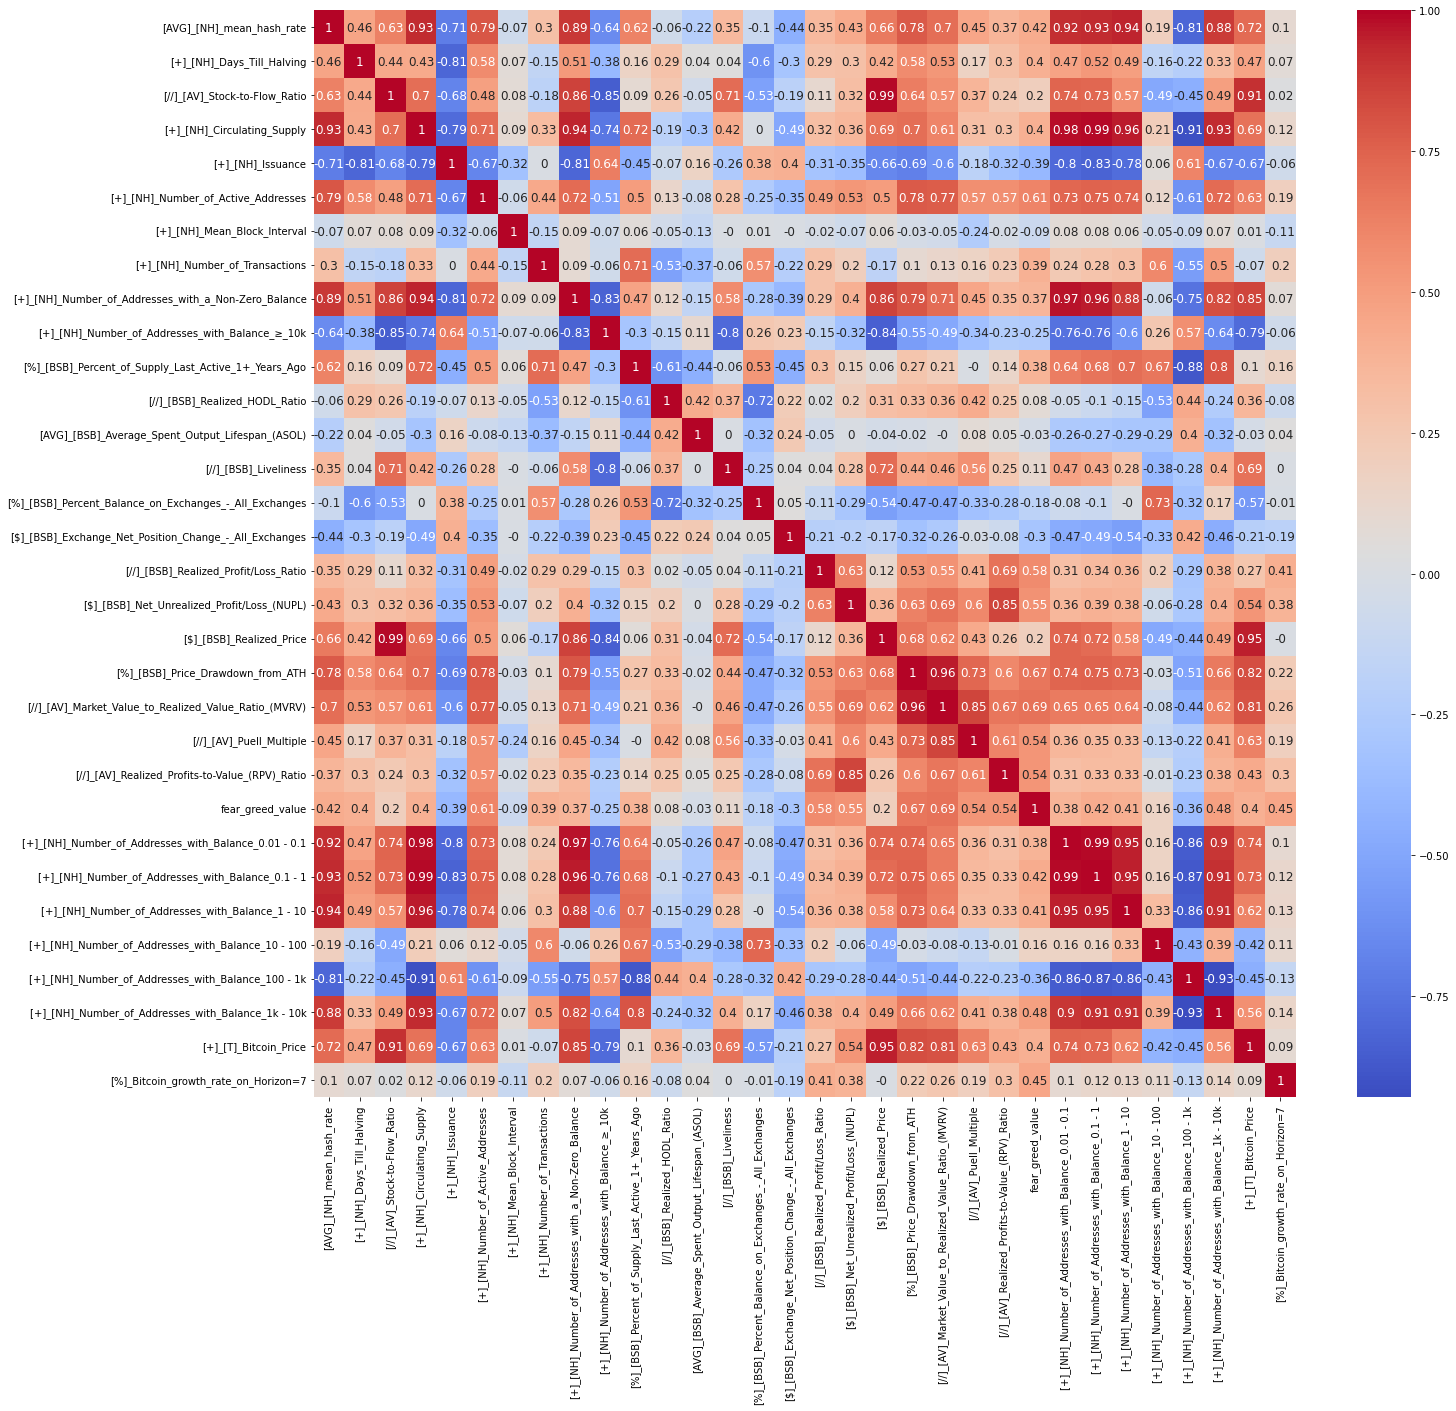

In [35]:
plt.figure(figsize = (22,20))
sns.heatmap(round(train_df_matrix.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12});

In [36]:
train_df_matrix.corr().style.background_gradient(cmap='coolwarm')

### VIF index

In [37]:
train_df_nodates = train_df.copy().drop(columns = 'date')#.drop(columns = bucket_list)

In [38]:
train_df_nodates_scaled = train_df_nodates.copy()

for feature in train_df_nodates_scaled.columns:
    mu = train_df_nodates[feature].mean()
    sigma = train_df_nodates[feature].std()
    train_df_nodates_scaled[feature] = train_df_nodates_scaled[feature].apply(lambda x: (x-mu)/sigma)

In [39]:
df = pd.DataFrame()

df["features"] = train_df_nodates_scaled.columns

df["vif_index"] = [vif(train_df_nodates_scaled.values, i) for i in range(train_df_nodates_scaled.shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2).reset_index(drop = True)

features  vif_index
0                         [+]_[NH]_Circulating_Supply     541.09
1                            [$]_[BSB]_Realized_Price     457.67
2                       [//]_[AV]_Stock-to-Flow_Ratio     290.22
3   [+]_[NH]_Number_of_Addresses_with_Balance_0.01...     276.45
4   [+]_[NH]_Number_of_Addresses_with_a_Non-Zero_B...     257.74
5   [+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1     237.33
6                               [+]_[T]_Bitcoin_Price     172.11
7   [//]_[AV]_Market_Value_to_Realized_Value_Ratio...     163.09
8    [+]_[NH]_Number_of_Addresses_with_Balance_1 - 10     100.08
9                   [%]_[BSB]_Price_Drawdown_from_ATH      79.25
10                           [//]_[AV]_Puell_Multiple      57.13
11                          [AVG]_[NH]_mean_hash_rate      52.13
12  [+]_[NH]_Number_of_Addresses_with_Balance_1k -...      50.72
13  [%]_[BSB]_Percent_Balance_on_Exchanges_-_All_E...      47.02
14  [%]_[BSB]_Percent_of_Supply_Last_Active_1+_Yea...      45.37
15  [+]_[NH]_Number_of_Addresses_with_Balance_100 ...      34.52
16                                  [+]_[NH]_Issuance      31.23
17    [+]_[NH]_Number_of_Addresses_with_Balance_≥_10k      25.97
18  [+]_[NH]_Number_of_Addresses_with_Balance_10 -...      21.98
19                              [//]_[BSB]_Liveliness      19.81
20                         [+]_[NH]_Days_Till_Halving      15.50
21                     [//]_[BSB]_Realized_HODL_Ratio      11.12
22                [+]_[NH]_Number_of_Active_Addresses      10.94
23                    [+]_[NH]_Number_of_Transactions       9.14
24    [//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio       7.32
25        [$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL)       7.06
26                                   fear_greed_value       5.51
27  [$]_[BSB]_Exchange_Net_Position_Change_-_All_E...       3.72
28              [//]_[BSB]_Realized_Profit/Loss_Ratio       2.82
29                       [+]_[NH]_Mean_Block_Interval       2.34
30               [%]_Bitcoin_growth_rate_on_Horizon=7       1.86
31   [AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL)       1.76

## Grid search and training

### Dummy model instanciating

In [72]:
# Instanciate model
dummy_model = DummyModel()
# Train and Fit data using the crossval
val_score,score = train(dummy_model,train_df);
print(val_score,score)

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 35.97it/s]

Training done
[0.06305, 0.08395, 0.11772, 0.1309, 0.13701, 0.12026, 0.11231, 0.10216, 0.09716, 0.0874, 0.07275, 0.14206, 0.15924, 0.17362, 0.0976, 0.06356, 0.05636, 0.06083, 0.06945, 0.05199, 0.05633, 0.08933, 0.13139, 0.16184, 0.14304, 0.15577, 0.14924, 0.15069, 0.11724, 0.08323, 0.0882, 0.08639] 0.10663


### Elastic Net Tuning

In [42]:
# Instanciate Grid Search
for counter in range(20):
    alpha = 0.015 * random()
    l1 = 0.002
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    train(regression_model,train_df);

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.05it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.67it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.28it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 29.75it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 29.32it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 28.70it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 23.24it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.82it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.91it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 18.81it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 28.63it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.86it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.85it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.78it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.98it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 24.71it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.12it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 30.37it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.64it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 33.30it/s]

Training done


In [70]:
alpha = 15
l1 = 0.003
# Instanciate model
regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
# Train and Fit data using the crossval
train(regression_model,train_df);

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 36.13it/s]

Training done


### RNN Tuning

In [80]:
# Instanciate Grid Search
for counter in range(1):
    l1_rnn = random() / 10
    l2_rnn = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1_rnn, L2 = l2_rnn, epochs = 20, patience = 5)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df);

  0%|                                                    | 0/32 [00:00<?, ?it/s]

Epoch 1/20
4/4 [==============================] - 2s 173ms/step - loss: 2.0553 - mae: 0.0742 - val_loss: 1.9731 - val_mae: 0.0703
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9503 - mae: 0.0758 - val_loss: 1.8957 - val_mae: 0.0693
Epoch 3/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8771 - mae: 0.0712 - val_loss: 1.8319 - val_mae: 0.0726
Epoch 4/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8154 - mae: 0.0732 - val_loss: 1.7729 - val_mae: 0.0722
Epoch 5/20
4/4 [==============================] - 0s 92ms/step - loss: 1.7571 - mae: 0.0712 - val_loss: 1.7190 - val_mae: 0.0792
Epoch 6/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7027 - mae: 0.0751 - val_loss: 1.6686 - val_mae: 0.0908
Epoch 7/20
4/4 [==============================] - 0s 92ms/step - loss: 1.6499 - mae: 0.0736 - val_loss: 1.6172 - val_mae: 0.0870
Epoch 8/20
4/4 [==============================] - 0s 91ms/step - loss: 1.5998 - mae: 0.0728 - va

  3%|█▍                                          | 1/32 [00:09<05:05,  9.85s/it]

Epoch 1/20
4/4 [==============================] - 3s 286ms/step - loss: 2.0888 - mae: 0.0802 - val_loss: 2.0024 - val_mae: 0.0580
Epoch 2/20
4/4 [==============================] - 0s 92ms/step - loss: 1.9841 - mae: 0.0840 - val_loss: 1.9224 - val_mae: 0.0422
Epoch 3/20
4/4 [==============================] - 0s 94ms/step - loss: 1.9101 - mae: 0.0762 - val_loss: 1.8582 - val_mae: 0.0462
Epoch 4/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8468 - mae: 0.0768 - val_loss: 1.7997 - val_mae: 0.0459
Epoch 5/20
4/4 [==============================] - 0s 92ms/step - loss: 1.7900 - mae: 0.0797 - val_loss: 1.7437 - val_mae: 0.0417
Epoch 6/20
4/4 [==============================] - 0s 93ms/step - loss: 1.7347 - mae: 0.0742 - val_loss: 1.6915 - val_mae: 0.0444
Epoch 7/20
4/4 [==============================] - 0s 92ms/step - loss: 1.6832 - mae: 0.0744 - val_loss: 1.6455 - val_mae: 0.0715
Epoch 8/20
4/4 [==============================] - 0s 93ms/step - loss: 1.6331 - mae: 0.0755 - va

  6%|██▊                                         | 2/32 [00:19<04:59,  9.99s/it]

Epoch 1/20
4/4 [==============================] - 2s 166ms/step - loss: 2.1229 - mae: 0.0922 - val_loss: 2.0339 - val_mae: 0.0677
Epoch 2/20
4/4 [==============================] - 0s 94ms/step - loss: 2.0132 - mae: 0.0704 - val_loss: 1.9557 - val_mae: 0.0589
Epoch 3/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9407 - mae: 0.0710 - val_loss: 1.8924 - val_mae: 0.0664
Epoch 4/20
4/4 [==============================] - 0s 96ms/step - loss: 1.8774 - mae: 0.0720 - val_loss: 1.8354 - val_mae: 0.0805
Epoch 5/20
4/4 [==============================] - 0s 93ms/step - loss: 1.8191 - mae: 0.0693 - val_loss: 1.7804 - val_mae: 0.0834
Epoch 6/20
4/4 [==============================] - 0s 92ms/step - loss: 1.7641 - mae: 0.0690 - val_loss: 1.7249 - val_mae: 0.0702
Epoch 7/20
4/4 [==============================] - 0s 93ms/step - loss: 1.7107 - mae: 0.0630 - val_loss: 1.6685 - val_mae: 0.0311
Epoch 8/20
4/4 [==============================] - 0s 92ms/step - loss: 1.6604 - mae: 0.0649 - va

  9%|████▏                                       | 3/32 [00:29<04:47,  9.90s/it]

Epoch 1/20
4/4 [==============================] - 3s 243ms/step - loss: 2.0950 - mae: 0.0667 - val_loss: 2.0117 - val_mae: 0.0460
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9902 - mae: 0.0625 - val_loss: 1.9516 - val_mae: 0.1302
Epoch 3/20
4/4 [==============================] - 0s 92ms/step - loss: 1.9183 - mae: 0.0655 - val_loss: 1.8716 - val_mae: 0.0559
Epoch 4/20
4/4 [==============================] - 0s 95ms/step - loss: 1.8542 - mae: 0.0581 - val_loss: 1.8118 - val_mae: 0.0471
Epoch 5/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7974 - mae: 0.0594 - val_loss: 1.7588 - val_mae: 0.0590
Epoch 6/20
4/4 [==============================] - 0s 92ms/step - loss: 1.7430 - mae: 0.0593 - val_loss: 1.7050 - val_mae: 0.0470
Epoch 7/20
4/4 [==============================] - 0s 93ms/step - loss: 1.6910 - mae: 0.0558 - val_loss: 1.6550 - val_mae: 0.0514
Epoch 8/20
4/4 [==============================] - 0s 93ms/step - loss: 1.6410 - mae: 0.0556 - va

 12%|█████▌                                      | 4/32 [00:39<04:37,  9.92s/it]

Epoch 1/20
4/4 [==============================] - 2s 166ms/step - loss: 2.0830 - mae: 0.0652 - val_loss: 2.0090 - val_mae: 0.0946
Epoch 2/20
4/4 [==============================] - 0s 94ms/step - loss: 1.9773 - mae: 0.0599 - val_loss: 1.9284 - val_mae: 0.0801
Epoch 3/20
4/4 [==============================] - 0s 92ms/step - loss: 1.9045 - mae: 0.0576 - val_loss: 1.8725 - val_mae: 0.1154
Epoch 4/20
4/4 [==============================] - 0s 91ms/step - loss: 1.8427 - mae: 0.0630 - val_loss: 1.8050 - val_mae: 0.0781
Epoch 5/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7846 - mae: 0.0603 - val_loss: 1.7508 - val_mae: 0.0808
Epoch 6/20
4/4 [==============================] - 0s 93ms/step - loss: 1.7301 - mae: 0.0570 - val_loss: 1.7020 - val_mae: 0.0937
Epoch 7/20
4/4 [==============================] - 0s 92ms/step - loss: 1.6796 - mae: 0.0630 - val_loss: 1.6496 - val_mae: 0.0866
Epoch 8/20
4/4 [==============================] - 0s 93ms/step - loss: 1.6290 - mae: 0.0595 - va

 16%|██████▉                                     | 5/32 [00:49<04:25,  9.85s/it]

Epoch 1/20
4/4 [==============================] - 3s 236ms/step - loss: 2.0751 - mae: 0.0625 - val_loss: 1.9989 - val_mae: 0.0940
Epoch 2/20
4/4 [==============================] - 0s 92ms/step - loss: 1.9710 - mae: 0.0596 - val_loss: 1.9260 - val_mae: 0.1057
Epoch 3/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8987 - mae: 0.0615 - val_loss: 1.8601 - val_mae: 0.0993
Epoch 4/20
4/4 [==============================] - 0s 93ms/step - loss: 1.8363 - mae: 0.0596 - val_loss: 1.8089 - val_mae: 0.1229
Epoch 5/20
4/4 [==============================] - 0s 103ms/step - loss: 1.7791 - mae: 0.0586 - val_loss: 1.7467 - val_mae: 0.0970
Epoch 6/20
4/4 [==============================] - 0s 95ms/step - loss: 1.7250 - mae: 0.0570 - val_loss: 1.6954 - val_mae: 0.1022
Epoch 7/20
4/4 [==============================] - 0s 106ms/step - loss: 1.6728 - mae: 0.0553 - val_loss: 1.6556 - val_mae: 0.1365
Epoch 8/20
4/4 [==============================] - 0s 105ms/step - loss: 1.6220 - mae: 0.0559 -

 19%|████████▎                                   | 6/32 [01:00<04:28, 10.32s/it]

Epoch 1/20
4/4 [==============================] - 2s 170ms/step - loss: 2.0999 - mae: 0.0932 - val_loss: 2.0198 - val_mae: 0.1024
Epoch 2/20
4/4 [==============================] - 0s 95ms/step - loss: 1.9905 - mae: 0.0692 - val_loss: 1.9456 - val_mae: 0.1066
Epoch 3/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9182 - mae: 0.0690 - val_loss: 1.8799 - val_mae: 0.1002
Epoch 4/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8545 - mae: 0.0637 - val_loss: 1.8198 - val_mae: 0.0959
Epoch 5/20
4/4 [==============================] - 0s 93ms/step - loss: 1.7971 - mae: 0.0638 - val_loss: 1.7748 - val_mae: 0.1244
Epoch 6/20
4/4 [==============================] - 0s 92ms/step - loss: 1.7429 - mae: 0.0666 - val_loss: 1.7162 - val_mae: 0.1099
Epoch 7/20
4/4 [==============================] - 0s 92ms/step - loss: 1.6896 - mae: 0.0623 - val_loss: 1.6618 - val_mae: 0.1035
Epoch 8/20
4/4 [==============================] - 0s 94ms/step - loss: 1.6402 - mae: 0.0687 - va

 22%|█████████▋                                  | 7/32 [01:10<04:13, 10.15s/it]

Epoch 1/20
4/4 [==============================] - 3s 291ms/step - loss: 2.1462 - mae: 0.0689 - val_loss: 2.0736 - val_mae: 0.0971
Epoch 2/20
4/4 [==============================] - 0s 95ms/step - loss: 2.0425 - mae: 0.0657 - val_loss: 2.0024 - val_mae: 0.1148
Epoch 3/20
4/4 [==============================] - 0s 91ms/step - loss: 1.9702 - mae: 0.0659 - val_loss: 1.9311 - val_mae: 0.0915
Epoch 4/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9077 - mae: 0.0650 - val_loss: 1.8767 - val_mae: 0.1051
Epoch 5/20
4/4 [==============================] - 0s 93ms/step - loss: 1.8499 - mae: 0.0626 - val_loss: 1.8223 - val_mae: 0.1070
Epoch 6/20
4/4 [==============================] - 0s 92ms/step - loss: 1.7955 - mae: 0.0613 - val_loss: 1.7727 - val_mae: 0.1178
Epoch 7/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7432 - mae: 0.0611 - val_loss: 1.7245 - val_mae: 0.1269
Epoch 8/20
4/4 [==============================] - 0s 93ms/step - loss: 1.6924 - mae: 0.0612 - va

 25%|███████████                                 | 8/32 [01:20<04:04, 10.17s/it]

Epoch 1/20
4/4 [==============================] - 2s 168ms/step - loss: 2.1346 - mae: 0.0747 - val_loss: 2.0519 - val_mae: 0.0717
Epoch 2/20
4/4 [==============================] - 0s 96ms/step - loss: 2.0282 - mae: 0.0637 - val_loss: 1.9741 - val_mae: 0.0667
Epoch 3/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9549 - mae: 0.0631 - val_loss: 1.9094 - val_mae: 0.0669
Epoch 4/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8924 - mae: 0.0624 - val_loss: 1.8530 - val_mae: 0.0832
Epoch 5/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8342 - mae: 0.0640 - val_loss: 1.7941 - val_mae: 0.0606
Epoch 6/20
4/4 [==============================] - 0s 92ms/step - loss: 1.7791 - mae: 0.0610 - val_loss: 1.7492 - val_mae: 0.1037
Epoch 7/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7267 - mae: 0.0613 - val_loss: 1.6929 - val_mae: 0.0843
Epoch 8/20
4/4 [==============================] - 0s 92ms/step - loss: 1.6762 - mae: 0.0657 - va

 28%|████████████▍                               | 9/32 [01:30<03:52, 10.11s/it]

Epoch 1/20
4/4 [==============================] - 3s 167ms/step - loss: 2.0908 - mae: 0.0736 - val_loss: 2.0095 - val_mae: 0.0632
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9848 - mae: 0.0695 - val_loss: 1.9295 - val_mae: 0.0539
Epoch 3/20
4/4 [==============================] - 0s 92ms/step - loss: 1.9119 - mae: 0.0696 - val_loss: 1.8647 - val_mae: 0.0627
Epoch 4/20
4/4 [==============================] - 0s 95ms/step - loss: 1.8495 - mae: 0.0732 - val_loss: 1.8082 - val_mae: 0.0659
Epoch 5/20
4/4 [==============================] - 0s 93ms/step - loss: 1.7909 - mae: 0.0704 - val_loss: 1.7508 - val_mae: 0.0553
Epoch 6/20
4/4 [==============================] - 0s 93ms/step - loss: 1.7359 - mae: 0.0689 - val_loss: 1.6974 - val_mae: 0.0527
Epoch 7/20
4/4 [==============================] - 0s 94ms/step - loss: 1.6833 - mae: 0.0686 - val_loss: 1.6484 - val_mae: 0.0651
Epoch 8/20
4/4 [==============================] - 0s 92ms/step - loss: 1.6325 - mae: 0.0675 - va

 31%|█████████████▍                             | 10/32 [01:40<03:41, 10.09s/it]

Epoch 1/20
4/4 [==============================] - 2s 182ms/step - loss: 2.1117 - mae: 0.0821 - val_loss: 2.0249 - val_mae: 0.0524
Epoch 2/20
4/4 [==============================] - 0s 96ms/step - loss: 2.0061 - mae: 0.0760 - val_loss: 1.9477 - val_mae: 0.0520
Epoch 3/20
4/4 [==============================] - 0s 92ms/step - loss: 1.9337 - mae: 0.0766 - val_loss: 1.8828 - val_mae: 0.0521
Epoch 4/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8699 - mae: 0.0748 - val_loss: 1.8247 - val_mae: 0.0516
Epoch 5/20
4/4 [==============================] - 0s 96ms/step - loss: 1.8123 - mae: 0.0750 - val_loss: 1.7683 - val_mae: 0.0519
Epoch 6/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7561 - mae: 0.0726 - val_loss: 1.7164 - val_mae: 0.0563
Epoch 7/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7043 - mae: 0.0756 - val_loss: 1.6633 - val_mae: 0.0514
Epoch 8/20
4/4 [==============================] - 0s 92ms/step - loss: 1.6522 - mae: 0.0714 - va

 34%|██████████████▊                            | 11/32 [01:50<03:30, 10.00s/it]

Epoch 1/20
4/4 [==============================] - 3s 166ms/step - loss: 2.1797 - mae: 0.0861 - val_loss: 2.0912 - val_mae: 0.0497
Epoch 2/20
4/4 [==============================] - 0s 94ms/step - loss: 2.0727 - mae: 0.0765 - val_loss: 2.0151 - val_mae: 0.0554
Epoch 3/20
4/4 [==============================] - 0s 95ms/step - loss: 1.9998 - mae: 0.0762 - val_loss: 1.9490 - val_mae: 0.0488
Epoch 4/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9364 - mae: 0.0753 - val_loss: 1.8899 - val_mae: 0.0498
Epoch 5/20
4/4 [==============================] - 0s 93ms/step - loss: 1.8781 - mae: 0.0742 - val_loss: 1.8348 - val_mae: 0.0510
Epoch 6/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8242 - mae: 0.0767 - val_loss: 1.7837 - val_mae: 0.0637
Epoch 7/20
4/4 [==============================] - 0s 93ms/step - loss: 1.7718 - mae: 0.0782 - val_loss: 1.7347 - val_mae: 0.0776
Epoch 8/20
4/4 [==============================] - 0s 92ms/step - loss: 1.7209 - mae: 0.0783 - va

 38%|████████████████▏                          | 12/32 [02:00<03:20, 10.01s/it]

Epoch 1/20
4/4 [==============================] - 2s 168ms/step - loss: 2.1328 - mae: 0.0873 - val_loss: 2.0430 - val_mae: 0.0414
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 2.0270 - mae: 0.0801 - val_loss: 1.9684 - val_mae: 0.0618
Epoch 3/20
4/4 [==============================] - 0s 92ms/step - loss: 1.9540 - mae: 0.0812 - val_loss: 1.9025 - val_mae: 0.0560
Epoch 4/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8901 - mae: 0.0773 - val_loss: 1.8406 - val_mae: 0.0398
Epoch 5/20
4/4 [==============================] - 0s 94ms/step - loss: 1.8323 - mae: 0.0785 - val_loss: 1.7877 - val_mae: 0.0524
Epoch 6/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7773 - mae: 0.0766 - val_loss: 1.7320 - val_mae: 0.0419
Epoch 7/20
4/4 [==============================] - 0s 116ms/step - loss: 1.7247 - mae: 0.0783 - val_loss: 1.6803 - val_mae: 0.0403
Epoch 8/20
4/4 [==============================] - 0s 96ms/step - loss: 1.6726 - mae: 0.0764 - v

 41%|█████████████████▍                         | 13/32 [02:10<03:08,  9.94s/it]

Epoch 1/20
4/4 [==============================] - 3s 166ms/step - loss: 2.0681 - mae: 0.0787 - val_loss: 1.9818 - val_mae: 0.0569
Epoch 2/20
4/4 [==============================] - 0s 92ms/step - loss: 1.9624 - mae: 0.0713 - val_loss: 1.9046 - val_mae: 0.0562
Epoch 3/20
4/4 [==============================] - 0s 93ms/step - loss: 1.8897 - mae: 0.0705 - val_loss: 1.8411 - val_mae: 0.0602
Epoch 4/20
4/4 [==============================] - 0s 90ms/step - loss: 1.8273 - mae: 0.0699 - val_loss: 1.7821 - val_mae: 0.0574
Epoch 5/20
4/4 [==============================] - 0s 92ms/step - loss: 1.7702 - mae: 0.0703 - val_loss: 1.7272 - val_mae: 0.0569
Epoch 6/20
4/4 [==============================] - 0s 90ms/step - loss: 1.7161 - mae: 0.0698 - val_loss: 1.6760 - val_mae: 0.0617
Epoch 7/20
4/4 [==============================] - 0s 90ms/step - loss: 1.6644 - mae: 0.0689 - val_loss: 1.6260 - val_mae: 0.0629
Epoch 8/20
4/4 [==============================] - 0s 93ms/step - loss: 1.6149 - mae: 0.0711 - va

 44%|██████████████████▊                        | 14/32 [02:20<02:58,  9.93s/it]

Epoch 1/20
4/4 [==============================] - 2s 168ms/step - loss: 2.1446 - mae: 0.0736 - val_loss: 2.1163 - val_mae: 0.1449
Epoch 2/20
4/4 [==============================] - 0s 91ms/step - loss: 2.0388 - mae: 0.0642 - val_loss: 2.0365 - val_mae: 0.1413
Epoch 3/20
4/4 [==============================] - 0s 90ms/step - loss: 1.9658 - mae: 0.0629 - val_loss: 1.9701 - val_mae: 0.1414
Epoch 4/20
4/4 [==============================] - 0s 90ms/step - loss: 1.9034 - mae: 0.0633 - val_loss: 1.9129 - val_mae: 0.1410
Epoch 5/20
4/4 [==============================] - 0s 90ms/step - loss: 1.8459 - mae: 0.0627 - val_loss: 1.8573 - val_mae: 0.1405
Epoch 6/20
4/4 [==============================] - 0s 92ms/step - loss: 1.7917 - mae: 0.0629 - val_loss: 1.8072 - val_mae: 0.1406
Epoch 7/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7392 - mae: 0.0618 - val_loss: 1.7589 - val_mae: 0.1437
Epoch 8/20
4/4 [==============================] - 0s 111ms/step - loss: 1.6882 - mae: 0.0623 - v

 47%|████████████████████▏                      | 15/32 [02:29<02:47,  9.87s/it]

Epoch 1/20
4/4 [==============================] - 3s 167ms/step - loss: 2.1198 - mae: 0.0622 - val_loss: 2.0919 - val_mae: 0.1491
Epoch 2/20
4/4 [==============================] - 0s 95ms/step - loss: 2.0147 - mae: 0.0585 - val_loss: 2.0160 - val_mae: 0.1484
Epoch 3/20
4/4 [==============================] - 0s 92ms/step - loss: 1.9412 - mae: 0.0587 - val_loss: 1.9510 - val_mae: 0.1482
Epoch 4/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8783 - mae: 0.0586 - val_loss: 1.8920 - val_mae: 0.1481
Epoch 5/20
4/4 [==============================] - 0s 91ms/step - loss: 1.8202 - mae: 0.0584 - val_loss: 1.8342 - val_mae: 0.1478
Epoch 6/20
4/4 [==============================] - 0s 93ms/step - loss: 1.7652 - mae: 0.0585 - val_loss: 1.7825 - val_mae: 0.1480
Epoch 7/20
4/4 [==============================] - 0s 91ms/step - loss: 1.7117 - mae: 0.0584 - val_loss: 1.7294 - val_mae: 0.1468
Epoch 8/20
4/4 [==============================] - 0s 92ms/step - loss: 1.6597 - mae: 0.0571 - va

 50%|█████████████████████▌                     | 16/32 [02:39<02:38,  9.90s/it]

Epoch 1/20
4/4 [==============================] - 2s 166ms/step - loss: 2.1196 - mae: 0.0816 - val_loss: 2.0249 - val_mae: 0.0610
Epoch 2/20
4/4 [==============================] - 0s 91ms/step - loss: 2.0158 - mae: 0.0840 - val_loss: 1.9507 - val_mae: 0.0689
Epoch 3/20
4/4 [==============================] - 0s 90ms/step - loss: 1.9435 - mae: 0.0809 - val_loss: 1.8876 - val_mae: 0.0727
Epoch 4/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8812 - mae: 0.0791 - val_loss: 1.8343 - val_mae: 0.0944
Epoch 5/20
4/4 [==============================] - 0s 91ms/step - loss: 1.8244 - mae: 0.0821 - val_loss: 1.7810 - val_mae: 0.1003
Epoch 6/20
4/4 [==============================] - 0s 92ms/step - loss: 1.7705 - mae: 0.0816 - val_loss: 1.7268 - val_mae: 0.0931
Epoch 7/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7185 - mae: 0.0828 - val_loss: 1.6709 - val_mae: 0.0710
Epoch 8/20
4/4 [==============================] - 0s 91ms/step - loss: 1.6676 - mae: 0.0799 - va

 53%|██████████████████████▊                    | 17/32 [02:49<02:27,  9.85s/it]

Epoch 1/20
4/4 [==============================] - 3s 165ms/step - loss: 2.0952 - mae: 0.0967 - val_loss: 1.9989 - val_mae: 0.0626
Epoch 2/20
4/4 [==============================] - 0s 91ms/step - loss: 1.9873 - mae: 0.0763 - val_loss: 1.9243 - val_mae: 0.0690
Epoch 3/20
4/4 [==============================] - 0s 91ms/step - loss: 1.9144 - mae: 0.0764 - val_loss: 1.8576 - val_mae: 0.0630
Epoch 4/20
4/4 [==============================] - 0s 93ms/step - loss: 1.8525 - mae: 0.0790 - val_loss: 1.7990 - val_mae: 0.0627
Epoch 5/20
4/4 [==============================] - 0s 107ms/step - loss: 1.7951 - mae: 0.0760 - val_loss: 1.7435 - val_mae: 0.0591
Epoch 6/20
4/4 [==============================] - 0s 100ms/step - loss: 1.7409 - mae: 0.0753 - val_loss: 1.6910 - val_mae: 0.0581
Epoch 7/20
4/4 [==============================] - 0s 123ms/step - loss: 1.6891 - mae: 0.0774 - val_loss: 1.6406 - val_mae: 0.0600
Epoch 8/20
4/4 [==============================] - 0s 116ms/step - loss: 1.6387 - mae: 0.0745 

 56%|████████████████████████▏                  | 18/32 [03:01<02:25, 10.38s/it]

Epoch 1/20
4/4 [==============================] - 2s 177ms/step - loss: 2.0533 - mae: 0.0810 - val_loss: 1.9553 - val_mae: 0.0329
Epoch 2/20
4/4 [==============================] - 0s 90ms/step - loss: 1.9486 - mae: 0.0845 - val_loss: 1.8775 - val_mae: 0.0279
Epoch 3/20
4/4 [==============================] - 0s 95ms/step - loss: 1.8758 - mae: 0.0790 - val_loss: 1.8129 - val_mae: 0.0257
Epoch 4/20
4/4 [==============================] - 0s 121ms/step - loss: 1.8130 - mae: 0.0804 - val_loss: 1.7541 - val_mae: 0.0267
Epoch 5/20
4/4 [==============================] - 0s 102ms/step - loss: 1.7551 - mae: 0.0816 - val_loss: 1.6991 - val_mae: 0.0268
Epoch 6/20
4/4 [==============================] - 0s 97ms/step - loss: 1.7012 - mae: 0.0806 - val_loss: 1.6464 - val_mae: 0.0272
Epoch 7/20
4/4 [==============================] - 0s 100ms/step - loss: 1.6474 - mae: 0.0769 - val_loss: 1.5962 - val_mae: 0.0400
Epoch 8/20
4/4 [==============================] - 0s 114ms/step - loss: 1.5986 - mae: 0.0828 

 59%|█████████████████████████▌                 | 19/32 [03:11<02:14, 10.36s/it]

Epoch 1/20
4/4 [==============================] - 3s 166ms/step - loss: 2.0395 - mae: 0.0760 - val_loss: 1.9438 - val_mae: 0.0400
Epoch 2/20
4/4 [==============================] - 0s 92ms/step - loss: 1.9343 - mae: 0.0742 - val_loss: 1.8661 - val_mae: 0.0401
Epoch 3/20
4/4 [==============================] - 0s 92ms/step - loss: 1.8617 - mae: 0.0731 - val_loss: 1.8044 - val_mae: 0.0542
Epoch 4/20
4/4 [==============================] - 0s 95ms/step - loss: 1.7995 - mae: 0.0783 - val_loss: 1.7431 - val_mae: 0.0374
Epoch 5/20
4/4 [==============================] - 0s 93ms/step - loss: 1.7416 - mae: 0.0707 - val_loss: 1.6898 - val_mae: 0.0453
Epoch 6/20
4/4 [==============================] - 0s 93ms/step - loss: 1.6867 - mae: 0.0712 - val_loss: 1.6356 - val_mae: 0.0382
Epoch 7/20
4/4 [==============================] - 0s 95ms/step - loss: 1.6354 - mae: 0.0736 - val_loss: 1.5846 - val_mae: 0.0361
Epoch 8/20
4/4 [==============================] - 0s 93ms/step - loss: 1.5842 - mae: 0.0701 - va

 62%|██████████████████████████▉                | 20/32 [03:22<02:04, 10.40s/it]

Epoch 1/20
4/4 [==============================] - 3s 173ms/step - loss: 2.1332 - mae: 0.0763 - val_loss: 2.0399 - val_mae: 0.0561
Epoch 2/20
4/4 [==============================] - 0s 100ms/step - loss: 2.0283 - mae: 0.0753 - val_loss: 1.9634 - val_mae: 0.0581
Epoch 3/20
4/4 [==============================] - 0s 123ms/step - loss: 1.9557 - mae: 0.0740 - val_loss: 1.8986 - val_mae: 0.0547
Epoch 4/20
4/4 [==============================] - 0s 118ms/step - loss: 1.8930 - mae: 0.0707 - val_loss: 1.8403 - val_mae: 0.0572
Epoch 5/20
4/4 [==============================] - 1s 145ms/step - loss: 1.8353 - mae: 0.0696 - val_loss: 1.7848 - val_mae: 0.0559
Epoch 6/20
4/4 [==============================] - 0s 102ms/step - loss: 1.7809 - mae: 0.0724 - val_loss: 1.7318 - val_mae: 0.0566
Epoch 7/20
4/4 [==============================] - 1s 125ms/step - loss: 1.7278 - mae: 0.0725 - val_loss: 1.6801 - val_mae: 0.0569
Epoch 8/20
4/4 [==============================] - 1s 131ms/step - loss: 1.6756 - mae: 0.06

 66%|████████████████████████████▏              | 21/32 [03:33<01:56, 10.62s/it]

Epoch 1/20
4/4 [==============================] - 3s 165ms/step - loss: 2.0871 - mae: 0.0804 - val_loss: 1.9921 - val_mae: 0.0478
Epoch 2/20
4/4 [==============================] - 0s 98ms/step - loss: 1.9829 - mae: 0.0734 - val_loss: 1.9143 - val_mae: 0.0437
Epoch 3/20
4/4 [==============================] - 0s 94ms/step - loss: 1.9097 - mae: 0.0734 - val_loss: 1.8499 - val_mae: 0.0444
Epoch 4/20
4/4 [==============================] - 0s 94ms/step - loss: 1.8473 - mae: 0.0735 - val_loss: 1.7918 - val_mae: 0.0448
Epoch 5/20
4/4 [==============================] - 0s 97ms/step - loss: 1.7902 - mae: 0.0734 - val_loss: 1.7372 - val_mae: 0.0448
Epoch 6/20
4/4 [==============================] - 0s 96ms/step - loss: 1.7363 - mae: 0.0721 - val_loss: 1.6862 - val_mae: 0.0495
Epoch 7/20
4/4 [==============================] - 0s 100ms/step - loss: 1.6850 - mae: 0.0717 - val_loss: 1.6351 - val_mae: 0.0438
Epoch 8/20
4/4 [==============================] - 0s 95ms/step - loss: 1.6350 - mae: 0.0717 - v

 69%|█████████████████████████████▌             | 22/32 [03:43<01:46, 10.63s/it]

Epoch 1/20
4/4 [==============================] - 2s 167ms/step - loss: 2.1366 - mae: 0.0743 - val_loss: 2.0425 - val_mae: 0.0615
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 2.0311 - mae: 0.0745 - val_loss: 1.9639 - val_mae: 0.0580
Epoch 3/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9563 - mae: 0.0744 - val_loss: 1.8976 - val_mae: 0.0547
Epoch 4/20
4/4 [==============================] - 0s 96ms/step - loss: 1.8924 - mae: 0.0780 - val_loss: 1.8366 - val_mae: 0.0419
Epoch 5/20
4/4 [==============================] - 0s 94ms/step - loss: 1.8355 - mae: 0.0739 - val_loss: 1.7824 - val_mae: 0.0576
Epoch 6/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7778 - mae: 0.0721 - val_loss: 1.7282 - val_mae: 0.0541
Epoch 7/20
4/4 [==============================] - 0s 96ms/step - loss: 1.7237 - mae: 0.0683 - val_loss: 1.6910 - val_mae: 0.1269
Epoch 8/20
4/4 [==============================] - 0s 94ms/step - loss: 1.6752 - mae: 0.0840 - va

 72%|██████████████████████████████▉            | 23/32 [03:53<01:33, 10.44s/it]

Epoch 1/20
4/4 [==============================] - 3s 167ms/step - loss: 2.1643 - mae: 0.0518 - val_loss: 2.0845 - val_mae: 0.0502
Epoch 2/20
4/4 [==============================] - 0s 103ms/step - loss: 2.0603 - mae: 0.0490 - val_loss: 2.0082 - val_mae: 0.0613
Epoch 3/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9876 - mae: 0.0467 - val_loss: 1.9444 - val_mae: 0.0658
Epoch 4/20
4/4 [==============================] - 0s 94ms/step - loss: 1.9253 - mae: 0.0471 - val_loss: 1.8859 - val_mae: 0.0667
Epoch 5/20
4/4 [==============================] - 0s 93ms/step - loss: 1.8674 - mae: 0.0460 - val_loss: 1.8296 - val_mae: 0.0604
Epoch 6/20
4/4 [==============================] - 0s 96ms/step - loss: 1.8128 - mae: 0.0465 - val_loss: 1.7772 - val_mae: 0.0649
Epoch 7/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7604 - mae: 0.0460 - val_loss: 1.7258 - val_mae: 0.0644
Epoch 8/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7094 - mae: 0.0458 - v

 75%|████████████████████████████████▎          | 24/32 [04:04<01:22, 10.37s/it]

Epoch 1/20
4/4 [==============================] - 2s 168ms/step - loss: 2.0810 - mae: 0.0536 - val_loss: 2.0103 - val_mae: 0.0994
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9759 - mae: 0.0487 - val_loss: 1.9313 - val_mae: 0.0942
Epoch 3/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9032 - mae: 0.0495 - val_loss: 1.8649 - val_mae: 0.0879
Epoch 4/20
4/4 [==============================] - 0s 96ms/step - loss: 1.8403 - mae: 0.0483 - val_loss: 1.8060 - val_mae: 0.0881
Epoch 5/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7823 - mae: 0.0474 - val_loss: 1.7502 - val_mae: 0.0867
Epoch 6/20
4/4 [==============================] - 0s 96ms/step - loss: 1.7275 - mae: 0.0453 - val_loss: 1.6973 - val_mae: 0.0871
Epoch 7/20
4/4 [==============================] - 0s 95ms/step - loss: 1.6750 - mae: 0.0449 - val_loss: 1.6501 - val_mae: 0.1010
Epoch 8/20
4/4 [==============================] - 0s 94ms/step - loss: 1.6243 - mae: 0.0462 - va

 78%|█████████████████████████████████▌         | 25/32 [04:13<01:11, 10.23s/it]

Epoch 1/20
4/4 [==============================] - 3s 168ms/step - loss: 2.1202 - mae: 0.0543 - val_loss: 2.0554 - val_mae: 0.1252
Epoch 2/20
4/4 [==============================] - 0s 92ms/step - loss: 2.0151 - mae: 0.0501 - val_loss: 1.9774 - val_mae: 0.1226
Epoch 3/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9420 - mae: 0.0498 - val_loss: 1.9119 - val_mae: 0.1216
Epoch 4/20
4/4 [==============================] - 0s 93ms/step - loss: 1.8788 - mae: 0.0497 - val_loss: 1.8523 - val_mae: 0.1203
Epoch 5/20
4/4 [==============================] - 0s 93ms/step - loss: 1.8208 - mae: 0.0501 - val_loss: 1.7956 - val_mae: 0.1176
Epoch 6/20
4/4 [==============================] - 0s 96ms/step - loss: 1.7652 - mae: 0.0501 - val_loss: 1.7419 - val_mae: 0.1184
Epoch 7/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7117 - mae: 0.0498 - val_loss: 1.6899 - val_mae: 0.1195
Epoch 8/20
4/4 [==============================] - 0s 94ms/step - loss: 1.6599 - mae: 0.0493 - va

 81%|██████████████████████████████████▉        | 26/32 [04:24<01:01, 10.19s/it]

Epoch 1/20
4/4 [==============================] - 2s 167ms/step - loss: 2.0921 - mae: 0.0625 - val_loss: 2.0215 - val_mae: 0.1000
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9883 - mae: 0.0601 - val_loss: 1.9449 - val_mae: 0.1019
Epoch 3/20
4/4 [==============================] - 0s 94ms/step - loss: 1.9159 - mae: 0.0597 - val_loss: 1.8809 - val_mae: 0.0974
Epoch 4/20
4/4 [==============================] - 0s 96ms/step - loss: 1.8540 - mae: 0.0590 - val_loss: 1.8223 - val_mae: 0.1004
Epoch 5/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7964 - mae: 0.0573 - val_loss: 1.7675 - val_mae: 0.1013
Epoch 6/20
4/4 [==============================] - 0s 96ms/step - loss: 1.7423 - mae: 0.0573 - val_loss: 1.7149 - val_mae: 0.0961
Epoch 7/20
4/4 [==============================] - 0s 94ms/step - loss: 1.6897 - mae: 0.0556 - val_loss: 1.6632 - val_mae: 0.0956
Epoch 8/20
4/4 [==============================] - 0s 94ms/step - loss: 1.6389 - mae: 0.0549 - va

 84%|████████████████████████████████████▎      | 27/32 [04:33<00:50, 10.10s/it]

Epoch 1/20
4/4 [==============================] - 3s 169ms/step - loss: 2.1655 - mae: 0.0755 - val_loss: 2.0876 - val_mae: 0.0785
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 2.0603 - mae: 0.0703 - val_loss: 2.0075 - val_mae: 0.0711
Epoch 3/20
4/4 [==============================] - 0s 94ms/step - loss: 1.9872 - mae: 0.0679 - val_loss: 1.9448 - val_mae: 0.0786
Epoch 4/20
4/4 [==============================] - 0s 97ms/step - loss: 1.9242 - mae: 0.0685 - val_loss: 1.8910 - val_mae: 0.0967
Epoch 5/20
4/4 [==============================] - 0s 94ms/step - loss: 1.8670 - mae: 0.0696 - val_loss: 1.8335 - val_mae: 0.0881
Epoch 6/20
4/4 [==============================] - 0s 98ms/step - loss: 1.8111 - mae: 0.0635 - val_loss: 1.7822 - val_mae: 0.0953
Epoch 7/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7580 - mae: 0.0614 - val_loss: 1.7261 - val_mae: 0.0796
Epoch 8/20
4/4 [==============================] - 0s 96ms/step - loss: 1.7078 - mae: 0.0656 - va

 88%|█████████████████████████████████████▋     | 28/32 [04:44<00:40, 10.17s/it]

Epoch 1/20
4/4 [==============================] - 2s 169ms/step - loss: 2.1445 - mae: 0.0829 - val_loss: 2.0633 - val_mae: 0.0783
Epoch 2/20
4/4 [==============================] - 0s 92ms/step - loss: 2.0386 - mae: 0.0782 - val_loss: 1.9884 - val_mae: 0.0854
Epoch 3/20
4/4 [==============================] - 0s 95ms/step - loss: 1.9646 - mae: 0.0732 - val_loss: 1.9208 - val_mae: 0.0787
Epoch 4/20
4/4 [==============================] - 0s 94ms/step - loss: 1.9018 - mae: 0.0769 - val_loss: 1.8642 - val_mae: 0.0866
Epoch 5/20
4/4 [==============================] - 0s 94ms/step - loss: 1.8426 - mae: 0.0713 - val_loss: 1.8137 - val_mae: 0.1066
Epoch 6/20
4/4 [==============================] - 0s 95ms/step - loss: 1.7872 - mae: 0.0704 - val_loss: 1.7544 - val_mae: 0.0872
Epoch 7/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7335 - mae: 0.0707 - val_loss: 1.7106 - val_mae: 0.1171
Epoch 8/20
4/4 [==============================] - 0s 95ms/step - loss: 1.6822 - mae: 0.0737 - va

 91%|██████████████████████████████████████▉    | 29/32 [04:54<00:30, 10.25s/it]

Epoch 1/20
4/4 [==============================] - 3s 171ms/step - loss: 2.0756 - mae: 0.1039 - val_loss: 2.0057 - val_mae: 0.1241
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9630 - mae: 0.0740 - val_loss: 1.9371 - val_mae: 0.1470
Epoch 3/20
4/4 [==============================] - 0s 95ms/step - loss: 1.8911 - mae: 0.0765 - val_loss: 1.8643 - val_mae: 0.1251
Epoch 4/20
4/4 [==============================] - 0s 95ms/step - loss: 1.8280 - mae: 0.0725 - val_loss: 1.8008 - val_mae: 0.1123
Epoch 5/20
4/4 [==============================] - 0s 94ms/step - loss: 1.7702 - mae: 0.0736 - val_loss: 1.7448 - val_mae: 0.1115
Epoch 6/20
4/4 [==============================] - 0s 96ms/step - loss: 1.7154 - mae: 0.0739 - val_loss: 1.6908 - val_mae: 0.1098
Epoch 7/20
4/4 [==============================] - 0s 95ms/step - loss: 1.6623 - mae: 0.0712 - val_loss: 1.6389 - val_mae: 0.1094
Epoch 8/20
4/4 [==============================] - 0s 94ms/step - loss: 1.6113 - mae: 0.0741 - va

 94%|████████████████████████████████████████▎  | 30/32 [05:05<00:20, 10.29s/it]

Epoch 1/20
4/4 [==============================] - 2s 170ms/step - loss: 2.0969 - mae: 0.1015 - val_loss: 2.0128 - val_mae: 0.0775
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 1.9924 - mae: 0.0936 - val_loss: 1.9373 - val_mae: 0.0826
Epoch 3/20
4/4 [==============================] - 0s 95ms/step - loss: 1.9193 - mae: 0.0889 - val_loss: 1.8723 - val_mae: 0.0793
Epoch 4/20
4/4 [==============================] - 0s 97ms/step - loss: 1.8564 - mae: 0.0870 - val_loss: 1.8122 - val_mae: 0.0707
Epoch 5/20
4/4 [==============================] - 0s 96ms/step - loss: 1.8002 - mae: 0.0911 - val_loss: 1.7576 - val_mae: 0.0711
Epoch 6/20
4/4 [==============================] - 0s 98ms/step - loss: 1.7462 - mae: 0.0897 - val_loss: 1.7046 - val_mae: 0.0662
Epoch 7/20
4/4 [==============================] - 0s 98ms/step - loss: 1.6941 - mae: 0.0896 - val_loss: 1.6551 - val_mae: 0.0715
Epoch 8/20
4/4 [==============================] - 0s 95ms/step - loss: 1.6438 - mae: 0.0870 - va

 97%|█████████████████████████████████████████▋ | 31/32 [05:15<00:10, 10.22s/it]

Epoch 1/20
4/4 [==============================] - 3s 170ms/step - loss: 2.1456 - mae: 0.0992 - val_loss: 2.0599 - val_mae: 0.0824
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 2.0403 - mae: 0.0941 - val_loss: 1.9831 - val_mae: 0.0824
Epoch 3/20
4/4 [==============================] - 0s 101ms/step - loss: 1.9675 - mae: 0.0917 - val_loss: 1.9187 - val_mae: 0.0826
Epoch 4/20
4/4 [==============================] - 0s 95ms/step - loss: 1.9055 - mae: 0.0951 - val_loss: 1.8600 - val_mae: 0.0827
Epoch 5/20
4/4 [==============================] - 0s 97ms/step - loss: 1.8474 - mae: 0.0919 - val_loss: 1.8052 - val_mae: 0.0830
Epoch 6/20
4/4 [==============================] - 0s 96ms/step - loss: 1.7930 - mae: 0.0925 - val_loss: 1.7530 - val_mae: 0.0831
Epoch 7/20
4/4 [==============================] - 0s 95ms/step - loss: 1.7416 - mae: 0.0947 - val_loss: 1.7024 - val_mae: 0.0830
Epoch 8/20
4/4 [==============================] - 0s 96ms/step - loss: 1.6910 - mae: 0.0916 - v

100%|███████████████████████████████████████████| 32/32 [05:25<00:00, 10.17s/it]

Training done


Epoch 1/20
4/4 [==============================] - 2s 167ms/step - loss: 2.5236 - mae: 0.0740 - val_loss: 2.4253 - val_mae: 0.0749
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 2.3973 - mae: 0.0729 - val_loss: 2.3313 - val_mae: 0.0734
Epoch 3/20
4/4 [==============================] - 0s 92ms/step - loss: 2.3085 - mae: 0.0733 - val_loss: 2.2529 - val_mae: 0.0734
Epoch 4/20
4/4 [==============================] - 0s 93ms/step - loss: 2.2325 - mae: 0.0737 - val_loss: 2.1817 - val_mae: 0.0737
Epoch 5/20
4/4 [==============================] - 0s 92ms/step - loss: 2.1626 - mae: 0.0740 - val_loss: 2.1148 - val_mae: 0.0740
Epoch 6/20
4/4 [==============================] - 0s 93ms/step - loss: 2.0964 - mae: 0.0742 - val_loss: 2.0507 - val_mae: 0.0753
Epoch 7/20
4/4 [==============================] - 0s 92ms/step - loss: 2.0326 - mae: 0.0753 - val_loss: 1.9887 - val_mae: 0.0763
Epoch 8/20
4/4 [==============================] - 0s 92ms/step - loss: 1.9706 - mae: 0.0758 - va

4/4 [==============================] - 0s 92ms/step - loss: 2.2765 - mae: 0.0657 - val_loss: 2.2237 - val_mae: 0.0518
Epoch 5/20
4/4 [==============================] - 0s 94ms/step - loss: 2.2050 - mae: 0.0578 - val_loss: 2.1645 - val_mae: 0.0895
Epoch 6/20
4/4 [==============================] - 0s 93ms/step - loss: 2.1398 - mae: 0.0602 - val_loss: 2.1124 - val_mae: 0.1357
Epoch 7/20
4/4 [==============================] - 0s 94ms/step - loss: 2.0773 - mae: 0.0621 - val_loss: 2.0333 - val_mae: 0.0595
Epoch 8/20
4/4 [==============================] - 0s 92ms/step - loss: 2.0150 - mae: 0.0581 - val_loss: 1.9736 - val_mae: 0.0631
Epoch 9/20
4/4 [==============================] - 0s 92ms/step - loss: 1.9541 - mae: 0.0536 - val_loss: 1.9133 - val_mae: 0.0551
Epoch 10/20
4/4 [==============================] - 0s 94ms/step - loss: 1.8975 - mae: 0.0630 - val_loss: 1.8554 - val_mae: 0.0557
Epoch 11/20
4/4 [==============================] - 0s 93ms/step - loss: 1.8379 - mae: 0.0535 - val_loss: 1.

4/4 [==============================] - 0s 93ms/step - loss: 2.0359 - mae: 0.0621 - val_loss: 2.0007 - val_mae: 0.1047
Epoch 8/20
4/4 [==============================] - 0s 107ms/step - loss: 1.9744 - mae: 0.0657 - val_loss: 1.9391 - val_mae: 0.1029
Epoch 9/20
4/4 [==============================] - 0s 96ms/step - loss: 1.9135 - mae: 0.0630 - val_loss: 1.8777 - val_mae: 0.0984
Epoch 10/20
4/4 [==============================] - 0s 118ms/step - loss: 1.8552 - mae: 0.0654 - val_loss: 1.8245 - val_mae: 0.1093
Epoch 11/20
4/4 [==============================] - 0s 116ms/step - loss: 1.7964 - mae: 0.0629 - val_loss: 1.7686 - val_mae: 0.1133
Epoch 12/20
4/4 [==============================] - 0s 125ms/step - loss: 1.7392 - mae: 0.0628 - val_loss: 1.7098 - val_mae: 0.1070
Epoch 13/20
4/4 [==============================] - 1s 118ms/step - loss: 1.6828 - mae: 0.0604 - val_loss: 1.6501 - val_mae: 0.0977
Epoch 14/20
4/4 [==============================] - 0s 122ms/step - loss: 1.6281 - mae: 0.0627 - val

4/4 [==============================] - 0s 97ms/step - loss: 1.9506 - mae: 0.0681 - val_loss: 1.9088 - val_mae: 0.0563
Epoch 11/20
4/4 [==============================] - 0s 97ms/step - loss: 1.8924 - mae: 0.0669 - val_loss: 1.8509 - val_mae: 0.0535
Epoch 12/20
4/4 [==============================] - 0s 97ms/step - loss: 1.8348 - mae: 0.0656 - val_loss: 1.8026 - val_mae: 0.0965
Epoch 13/20
4/4 [==============================] - 0s 97ms/step - loss: 1.7788 - mae: 0.0693 - val_loss: 1.7427 - val_mae: 0.0786
Epoch 14/20
4/4 [==============================] - 0s 101ms/step - loss: 1.7229 - mae: 0.0672 - val_loss: 1.6838 - val_mae: 0.0570
Epoch 15/20
4/4 [==============================] - 0s 95ms/step - loss: 1.6681 - mae: 0.0677 - val_loss: 1.6293 - val_mae: 0.0630
Epoch 16/20
4/4 [==============================] - 0s 99ms/step - loss: 1.6144 - mae: 0.0682 - val_loss: 1.5773 - val_mae: 0.0616
Epoch 17/20
4/4 [==============================] - 0s 97ms/step - loss: 1.5618 - mae: 0.0696 - val_lo

4/4 [==============================] - 0s 95ms/step - loss: 1.7432 - mae: 0.0705 - val_loss: 1.7006 - val_mae: 0.0557
Epoch 14/20
4/4 [==============================] - 0s 97ms/step - loss: 1.6886 - mae: 0.0708 - val_loss: 1.6441 - val_mae: 0.0416
Epoch 15/20
4/4 [==============================] - 0s 94ms/step - loss: 1.6345 - mae: 0.0699 - val_loss: 1.5908 - val_mae: 0.0414
Epoch 16/20
4/4 [==============================] - 0s 94ms/step - loss: 1.5816 - mae: 0.0709 - val_loss: 1.5392 - val_mae: 0.0441
Epoch 17/20
4/4 [==============================] - 0s 97ms/step - loss: 1.5296 - mae: 0.0697 - val_loss: 1.4877 - val_mae: 0.0407
Epoch 18/20
4/4 [==============================] - 0s 95ms/step - loss: 1.4790 - mae: 0.0717 - val_loss: 1.4370 - val_mae: 0.0414
Epoch 19/20
4/4 [==============================] - 0s 96ms/step - loss: 1.4279 - mae: 0.0675 - val_loss: 1.3895 - val_mae: 0.0505
Epoch 20/20
4/4 [==============================] - 0s 95ms/step - loss: 1.3792 - mae: 0.0702 - val_los

4/4 [==============================] - 0s 97ms/step - loss: 1.5501 - mae: 0.0591 - val_loss: 1.5691 - val_mae: 0.1478
Epoch 17/20
4/4 [==============================] - 0s 94ms/step - loss: 1.4974 - mae: 0.0556 - val_loss: 1.5157 - val_mae: 0.1444
Epoch 18/20
4/4 [==============================] - 0s 96ms/step - loss: 1.4467 - mae: 0.0575 - val_loss: 1.4675 - val_mae: 0.1475
Epoch 19/20
4/4 [==============================] - 0s 96ms/step - loss: 1.3964 - mae: 0.0553 - val_loss: 1.4175 - val_mae: 0.1457
Epoch 20/20
4/4 [==============================] - 0s 94ms/step - loss: 1.3471 - mae: 0.0543 - val_loss: 1.3702 - val_mae: 0.1483
Epoch 1/20
4/4 [==============================] - 2s 171ms/step - loss: 2.5764 - mae: 0.0815 - val_loss: 2.4694 - val_mae: 0.0796
Epoch 2/20
4/4 [==============================] - 0s 92ms/step - loss: 2.4505 - mae: 0.0800 - val_loss: 2.3741 - val_mae: 0.0719
Epoch 3/20
4/4 [==============================] - 0s 95ms/step - loss: 2.3622 - mae: 0.0799 - val_loss:

4/4 [==============================] - 0s 97ms/step - loss: 1.4284 - mae: 0.0738 - val_loss: 1.3837 - val_mae: 0.0806
Epoch 20/20
4/4 [==============================] - 0s 96ms/step - loss: 1.3764 - mae: 0.0740 - val_loss: 1.3318 - val_mae: 0.0677
Epoch 1/20
4/4 [==============================] - 2s 174ms/step - loss: 2.6082 - mae: 0.0821 - val_loss: 2.4942 - val_mae: 0.0373
Epoch 2/20
4/4 [==============================] - 0s 94ms/step - loss: 2.4790 - mae: 0.0722 - val_loss: 2.4010 - val_mae: 0.0447
Epoch 3/20
4/4 [==============================] - 0s 96ms/step - loss: 2.3926 - mae: 0.0777 - val_loss: 2.3223 - val_mae: 0.0376
Epoch 4/20
4/4 [==============================] - 0s 94ms/step - loss: 2.3146 - mae: 0.0717 - val_loss: 2.2557 - val_mae: 0.0721
Epoch 5/20
4/4 [==============================] - 0s 95ms/step - loss: 2.2446 - mae: 0.0739 - val_loss: 2.1829 - val_mae: 0.0373
Epoch 6/20
4/4 [==============================] - 0s 96ms/step - loss: 2.1771 - mae: 0.0689 - val_loss: 2.

4/4 [==============================] - 0s 94ms/step - loss: 2.4926 - mae: 0.0786 - val_loss: 2.4128 - val_mae: 0.0558
Epoch 3/20
4/4 [==============================] - 0s 96ms/step - loss: 2.4020 - mae: 0.0738 - val_loss: 2.3334 - val_mae: 0.0514
Epoch 4/20
4/4 [==============================] - 0s 94ms/step - loss: 2.3251 - mae: 0.0708 - val_loss: 2.2618 - val_mae: 0.0494
Epoch 5/20
4/4 [==============================] - 0s 94ms/step - loss: 2.2534 - mae: 0.0695 - val_loss: 2.2019 - val_mae: 0.0882
Epoch 6/20
4/4 [==============================] - 0s 97ms/step - loss: 2.1896 - mae: 0.0832 - val_loss: 2.1308 - val_mae: 0.0537
Epoch 7/20
4/4 [==============================] - 0s 95ms/step - loss: 2.1220 - mae: 0.0696 - val_loss: 2.0680 - val_mae: 0.0550
Epoch 8/20
4/4 [==============================] - 0s 97ms/step - loss: 2.0602 - mae: 0.0705 - val_loss: 2.0055 - val_mae: 0.0487
Epoch 9/20
4/4 [==============================] - 0s 96ms/step - loss: 1.9980 - mae: 0.0689 - val_loss: 1.94

4/4 [==============================] - 0s 95ms/step - loss: 2.1828 - mae: 0.0493 - val_loss: 2.1489 - val_mae: 0.1148
Epoch 6/20
4/4 [==============================] - 0s 95ms/step - loss: 2.1158 - mae: 0.0492 - val_loss: 2.0831 - val_mae: 0.1114
Epoch 7/20
4/4 [==============================] - 0s 97ms/step - loss: 2.0514 - mae: 0.0501 - val_loss: 2.0210 - val_mae: 0.1153
Epoch 8/20
4/4 [==============================] - 0s 95ms/step - loss: 1.9889 - mae: 0.0484 - val_loss: 1.9600 - val_mae: 0.1155
Epoch 9/20
4/4 [==============================] - 0s 97ms/step - loss: 1.9282 - mae: 0.0478 - val_loss: 1.8988 - val_mae: 0.1034
Epoch 10/20
4/4 [==============================] - 0s 95ms/step - loss: 1.8691 - mae: 0.0491 - val_loss: 1.8407 - val_mae: 0.1099
Epoch 11/20
4/4 [==============================] - 0s 99ms/step - loss: 1.8110 - mae: 0.0475 - val_loss: 1.7890 - val_mae: 0.1308
Epoch 12/20
4/4 [==============================] - 0s 101ms/step - loss: 1.7548 - mae: 0.0505 - val_loss: 

4/4 [==============================] - 0s 96ms/step - loss: 1.9266 - mae: 0.0747 - val_loss: 1.8921 - val_mae: 0.0965
Epoch 9/20
4/4 [==============================] - 0s 98ms/step - loss: 1.8667 - mae: 0.0694 - val_loss: 1.8300 - val_mae: 0.0821
Epoch 10/20
4/4 [==============================] - 0s 96ms/step - loss: 1.8091 - mae: 0.0700 - val_loss: 1.7773 - val_mae: 0.0941
Epoch 11/20
4/4 [==============================] - 0s 98ms/step - loss: 1.7535 - mae: 0.0696 - val_loss: 1.7333 - val_mae: 0.1296
Epoch 12/20
4/4 [==============================] - 0s 97ms/step - loss: 1.6992 - mae: 0.0699 - val_loss: 1.6682 - val_mae: 0.0938
Epoch 13/20
4/4 [==============================] - 0s 95ms/step - loss: 1.6440 - mae: 0.0664 - val_loss: 1.6290 - val_mae: 0.1395
Epoch 14/20
4/4 [==============================] - 0s 99ms/step - loss: 1.5914 - mae: 0.0691 - val_loss: 1.5689 - val_mae: 0.1169
Epoch 15/20
4/4 [==============================] - 0s 97ms/step - loss: 1.5395 - mae: 0.0699 - val_loss

4/4 [==============================] - 0s 97ms/step - loss: 1.7865 - mae: 0.0877 - val_loss: 1.7472 - val_mae: 0.0875
Epoch 12/20
4/4 [==============================] - 0s 99ms/step - loss: 1.7315 - mae: 0.0924 - val_loss: 1.6892 - val_mae: 0.0836
Epoch 13/20
4/4 [==============================] - 0s 96ms/step - loss: 1.6746 - mae: 0.0886 - val_loss: 1.6359 - val_mae: 0.0867
Epoch 14/20
4/4 [==============================] - 0s 96ms/step - loss: 1.6189 - mae: 0.0872 - val_loss: 1.5856 - val_mae: 0.1004
Epoch 15/20
4/4 [==============================] - 0s 97ms/step - loss: 1.5661 - mae: 0.0904 - val_loss: 1.5273 - val_mae: 0.0849
Epoch 16/20
4/4 [==============================] - 0s 96ms/step - loss: 1.5113 - mae: 0.0850 - val_loss: 1.4743 - val_mae: 0.0847
Epoch 17/20
4/4 [==============================] - 0s 98ms/step - loss: 1.4605 - mae: 0.0894 - val_loss: 1.4261 - val_mae: 0.0935
Epoch 18/20
4/4 [==============================] - 0s 97ms/step - loss: 1.4070 - mae: 0.0815 - val_los

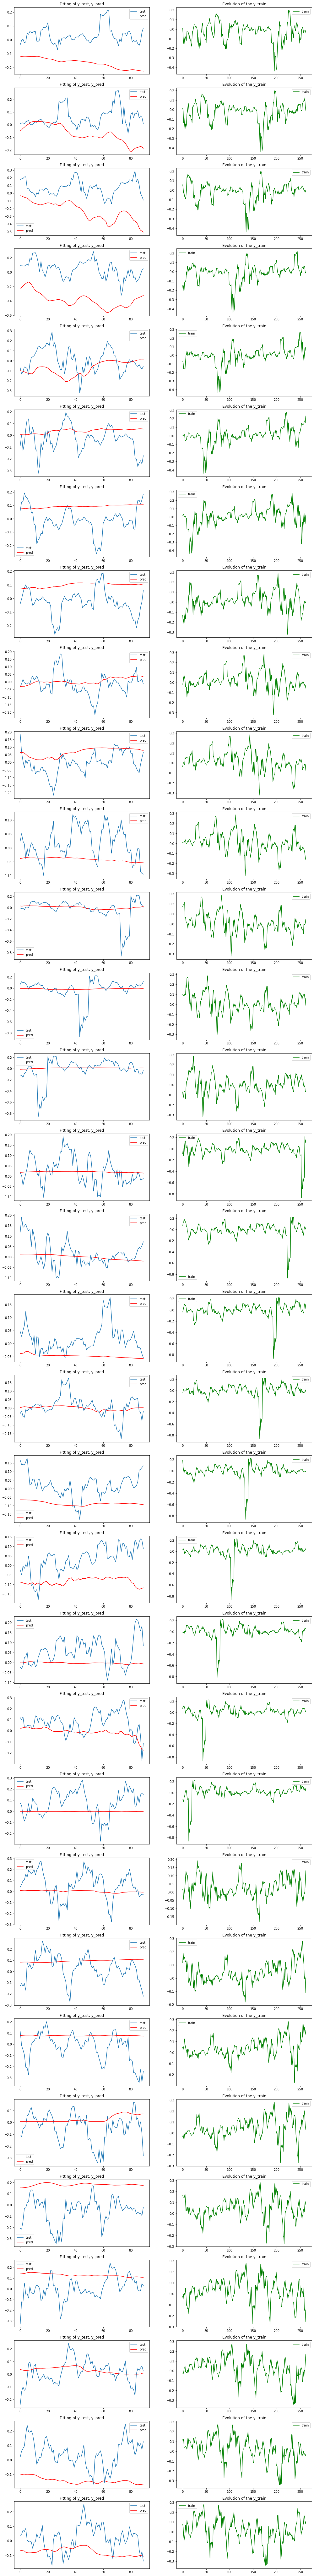

In [85]:
l1_rnn = 0.01653480436240602
l2_rnn = 0.0792386474

plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, RnnDlModel(L1 = l1_rnn, L2 = l2_rnn, epochs = 20, patience = 5))

### Exporting and viewing results

In [81]:
df_result = read_result()
df_result = df_result.sort_values(by="mean_score", ascending = True)
df_result

name                                         fold_score  mean_score  \
32  LinearReg  [0.06418, 0.08195, 0.10259, 0.10487, 0.09254, ...     0.07992   
31  LinearReg  [0.06418, 0.08195, 0.10259, 0.10487, 0.09254, ...     0.07993   
29  LinearReg  [0.06397, 0.08152, 0.10241, 0.10399, 0.09277, ...     0.08005   
28  LinearReg  [0.06397, 0.08152, 0.10241, 0.10399, 0.09277, ...     0.08005   
30  LinearReg  [0.06398, 0.08127, 0.10228, 0.10385, 0.0928, 0...     0.08006   
27  LinearReg  [0.06338, 0.0794, 0.10275, 0.09948, 0.0973, 0....     0.08263   
26  LinearReg  [0.06363, 0.08038, 0.10545, 0.09817, 0.10164, ...     0.08537   
25  LinearReg  [0.06441, 0.08361, 0.11218, 0.09743, 0.11056, ...     0.09059   
34        RNN  [0.05114, 0.08591, 0.10552, 0.37322, 0.09235, ...     0.09072   
24  LinearReg  [0.06332, 0.09305, 0.13736, 0.09916, 0.13566, ...     0.10661   
33      Dummy  [0.06305, 0.08395, 0.11772, 0.1309, 0.13701, 0...     0.10663   
23  LinearReg  [0.05853, 0.09651, 0.15325, 0.10178, 0.15352, ...     0.11766   
35        RNN  [0.15639, 0.1727, 0.19486, 0.24519, 0.09248, 0...     0.11958   
20  LinearReg  [0.05378, 0.09703, 0.16193, 0.10382, 0.1663, 0...     0.12556   
21  LinearReg  [0.05374, 0.09762, 0.16306, 0.10406, 0.16696, ...     0.12609   
22  LinearReg  [0.05002, 0.09786, 0.16897, 0.10582, 0.1765, 0...     0.13240   
12  LinearReg  [0.04887, 0.09403, 0.18706, 0.11978, 0.21864, ...     0.17387   
14  LinearReg  [0.04972, 0.09364, 0.1876, 0.12088, 0.22012, 0...     0.17620   
18  LinearReg  [0.04972, 0.09363, 0.1876, 0.12088, 0.22013, 0...     0.17620   
13  LinearReg  [0.04992, 0.09355, 0.18773, 0.12115, 0.22047, ...     0.17675   
19  LinearReg  [0.05095, 0.09316, 0.18832, 0.12247, 0.2221, 0...     0.17950   
8   LinearReg  [0.05189, 0.09284, 0.1888, 0.1236, 0.22348, 0....     0.18191   
7   LinearReg  [0.05247, 0.09266, 0.18907, 0.12423, 0.22422, ...     0.18327   
2   LinearReg  [0.05917, 0.091, 0.19137, 0.13017, 0.22998, 0....     0.19574   
16  LinearReg  [0.05969, 0.09088, 0.19153, 0.13061, 0.23032, ...     0.19663   
0   LinearReg  [0.05985, 0.09084, 0.19158, 0.13074, 0.23041, ...     0.19690   
1   LinearReg  [0.06094, 0.0906, 0.1919, 0.13167, 0.23103, 0....     0.19876   
11  LinearReg  [0.06256, 0.09024, 0.19238, 0.13304, 0.23189, ...     0.20136   
3   LinearReg  [0.09345, 0.08633, 0.2009, 0.1547, 0.23918, 0....     0.24679   
17  LinearReg  [0.09664, 0.0863, 0.20182, 0.15661, 0.2393, 0....     0.25093   
4   LinearReg  [0.10902, 0.08641, 0.20571, 0.16387, 0.2393, 0...     0.26697   
5   LinearReg  [0.11744, 0.08688, 0.20872, 0.16872, 0.23916, ...     0.27800   
10  LinearReg  [0.11799, 0.08693, 0.20893, 0.16904, 0.23916, ...     0.27873   
15  LinearReg  [0.15584, 0.09405, 0.23072, 0.19401, 0.24038, ...     0.33716   
6   LinearReg  [0.16724, 0.09923, 0.241, 0.20344, 0.24237, 0....     0.35928   
9   LinearReg  [0.19212, 0.12126, 0.27593, 0.22954, 0.25452, ...     0.42177   

    min_score  max_score                                        hyperparams  \
32    0.03823    0.11913                   {'alpha': 15, 'l1_ratio': 0.003}   
31    0.03823    0.11913                   {'alpha': 15, 'l1_ratio': 0.001}   
29    0.03821    0.11900                  {'alpha': 15, 'l1_ratio': 0.0001}   
28    0.03821    0.11900                  {'alpha': 15, 'l1_ratio': 0.0001}   
30    0.03803    0.11893                   {'alpha': 15, 'l1_ratio': 1e-05}   
27    0.03793    0.11854                 {'alpha': 1.5, 'l1_ratio': 0.0001}   
26    0.03959    0.12842                 {'alpha': 0.8, 'l1_ratio': 0.0001}   
25    0.04440    0.14133                 {'alpha': 0.4, 'l1_ratio': 0.0001}   
34    0.04465    0.37322  {'L1': 0.01653480436240602, 'L2': 0.0792386474...   
24    0.04248    0.18896                {'alpha': 0.12, 'l1_ratio': 0.0001}   
33    0.05199    0.17362                                                NaN   
23    0.04178    0.22878                {'alpha': 0.07, 'l1_ratio': 0.0001}   
35    0.04566    0.24

## (Optionnal) Plotting scores on cross validated models

In [ ]:
# Instanciate Grid Search
scores_regression = []
scores_baseline = []
scores_rnn = []
for counter in range(10):
    alpha = 50 * random()
    l1 = 0.001
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    fold_score, score = train(regression_model,train_df)
    scores.append(score)
    # Instanciate model
    dummy_model = DummyModel()
    # Train and Fit data using the crossval
    train(dummy_model,train_df)
    l1_rnn = random() / 10
    l2_rnn = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1_rnn, L2 = l2_rnn, epochs = 2, patience = 10)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df)

#Plotting
plt.plot(scores_regression, color = 'r', label = 'regression')
plt.plot(scores_baseline, color = 'b', label = 'last value')
plt.plot(scores_rnn, color = 'g', label = 'rnn')
plt.legend()
plt.title('Model scores comparison chart')


In [44]:
import json

alpha = json.loads((np.array(pd.DataFrame(df_result.iloc[1,:]).iloc[-2,:])[0]).replace("'", "\""))['alpha']
l1_ratio = json.loads((np.array(pd.DataFrame(df_result.iloc[1,:]).iloc[-2,:])[0]).replace("'", "\""))['l1_ratio']
print(alpha)
print(l1_ratio)


0.09826776612681243
0.001
